In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random
import matplotlib.pyplot as plt

import copy
import timeit
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Hyper parameters

SEQUENCE_LENGTH = 50
INPUT_SIZE = 1
LR = 0.01
BATCH_SIZE = 64
HIDDEN_SIZE = 4
NUM_LAYERS = 1
RNN_TYPE = 'LSTM'
NUM_EPOCHS = 10



/home/liu/py3venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


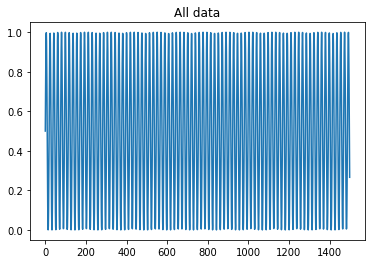

In [3]:
time_steps = np.linspace(0, 1000, 1500, dtype = np.float32)
sin_time_steps = np.sin(time_steps*0.5)

scaler = MinMaxScaler(feature_range=(0, 1))
sin_time_steps = scaler.fit_transform(sin_time_steps)

plt.plot(sin_time_steps[:])
plt.title("All data")
plt.show()

In [4]:
seqyence_length = SEQUENCE_LENGTH + 1
sequence_data = []
for i in range(len(sin_time_steps) - seqyence_length + 1):
    sequence_data.append(sin_time_steps[i:i + seqyence_length])
sequence_data = np.array(sequence_data)

In [8]:
num_samples = sequence_data.shape[0]
num_train = int(0.8 * num_samples)

train_set = sequence_data[:num_train, :]
test_set = sequence_data[num_train:, :]

np.random.shuffle(train_set)
print('{} total sequence sample samples, {} uesed for training'.format(num_samples, num_train))


1450 total sequence sample samples, 1160 uesed for training


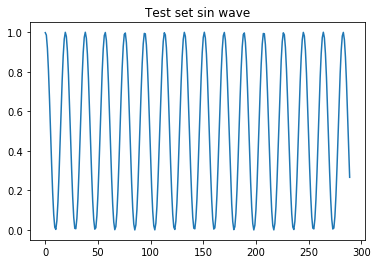

In [9]:
x_train = train_set[:, :-1][:,:,np.newaxis]
y_train = train_set[:, -1][:, np.newaxis]
x_test = test_set[:, :-1][:,:,np.newaxis]
y_test = test_set[:, -1][:, np.newaxis]

plt.plot(y_test[:])
plt.title("Test set sin wave")
plt.show()

In [12]:
class SimpleRNN(nn.Module):
    
    def __init__(self):
        super(SimpleRNN, self).__init__()
        
        if RNN_TYPE == 'RNN':
            self.rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, 
                              dropout=0.05, num_layers=NUM_LAYERS, batch_first=True)
        elif RNN_TYPE == 'LSTM':
            self.rnn = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, 
                              dropout=0.05, num_layers=NUM_LAYERS, batch_first=True)
        elif RNN_TYPE == 'GRU':
            self.rnn = nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, 
                              dropout=0.05, num_layers=NUM_LAYERS, batch_first=True)
        self.out = nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        final_y = self.out(r_out[:, -1, :])
        return final_y, h_state

rnn = SimpleRNN()
print(rnn)

SimpleRNN (
  (rnn): LSTM(1, 4, batch_first=True, dropout=0.05)
  (out): Linear (4 -> 1)
)


In [17]:
"""
if torch.cuda.is_available:
    dtype = torch.cuda.FloatTensor
    rnn = copy.deepcopy(rnn).type(dtype)
else:
    dtype = torch.FloatTensor
"""
dtype = torch.FloatTensor 
"""
AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx
""" 

'\nAssertionError: \nFound no NVIDIA driver on your system. Please check that you\nhave an NVIDIA GPU and installed a driver from\nhttp://www.nvidia.com/Download/index.aspx\n'

In [15]:
# Initialise the optimiser
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [19]:
#Covert the hidden, cell state, train data & labels to gpu/cpu type
h_state = Variable(torch.zeros(NUM_LAYERS*1, BATCH_SIZE, HIDDEN_SIZE).type(dtype))
c_state = Variable(torch.zeros(NUM_LAYERS*1, BATCH_SIZE, HIDDEN_SIZE).type(dtype))
x_batch_all = Variable(torch.from_numpy(x_train).type(dtype))
labels_all = Variable(torch.from_numpy(y_train).type(dtype))


loss: [  7.71046107e-05]


loss: [  7.22364639e-05]


loss: [  6.94599294e-05]


loss: [  6.57637793e-05]


loss: [  6.00741878e-05]


loss: [  5.41462141e-05]


loss: [  4.96822431e-05]


loss: [  4.66222336e-05]


loss: [  4.42434066e-05]


loss: [  4.21167206e-05]


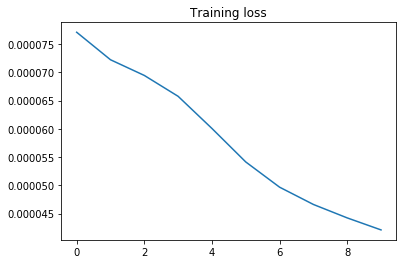

In [31]:
#Train loop
loss_all = []
for epoch in range(NUM_EPOCHS):
    for i in range(int(len(x_train)/BATCH_SIZE)):
        #Get a batch of data and lables
        x_batch = x_batch_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE,:,:]
        labels = labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
        
        #Zero our gradients
        optimizer.zero_grad()
        
        #Run our chosen rnn model
        if RNN_TYPE in {'RNN', 'GRU'}:
            output, _ = rnn(x_batch, (h_state))
        elif RNN_TYPE in {'LSTM'}:
            output, _ = rnn(x_batch, (h_state, c_state))
            
        #Calculate loss
        loss = loss_func(output, labels)
        
        #Backprop the loss
        loss.backward()
        
        #Perform an update step
        optimizer.step()
        
    loss_all.append(loss.cpu().data.numpy())
    print('loss:', loss.cpu().data.numpy())
    
plt.plot(loss_all)
plt.title('Training loss')
plt.show()

#Question: The results of every time is diffirent?

In [37]:
#Test our trained model
h_state = Variable(torch.zeros(NUM_LAYERS*1,1, HIDDEN_SIZE).type(dtype))
c_state = Variable(torch.zeros(NUM_LAYERS*1,1, HIDDEN_SIZE).type(dtype))
inital_input = Variable(torch.from_numpy(y_test[0:SEQUENCE_LENGTH,:]).type(dtype))
inital_input.data.unsqueeze_(0)

final_outputs = []

for i in range(int(len(y_test/2) - SEQUENCE_LENGTH)):
    if RNN_TYPE in {'RNN', 'GRU'}:
        output, _ = rnn(inital_input, (h_state))
    elif RNN_TYPE in {'LSTM'}:
        output, _ = rnn(inital_input, (h_state, c_state))
        
    final_outputs.append(output.cpu().data.numpy())
    
    # Pop off the first element of the sequence and then add on our latest generated point (use our predicted value in prediction).
    inital_input.data[:,0:SEQUENCE_LENGTH-1,:] = inital_input.data[:,1:SEQUENCE_LENGTH,:]
    inital_input.data[:,SEQUENCE_LENGTH-1,:] = output.data

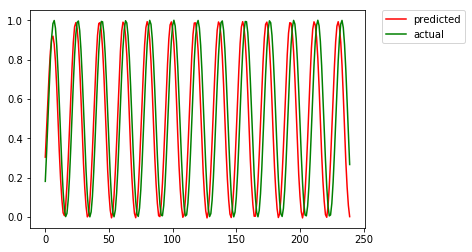

In [42]:
final_pred = np.array(final_outputs).squeeze()

plt.plot(final_pred, label = 'predicted', color='red')
plt.plot(y_test[SEQUENCE_LENGTH:], label = 'actual',color='green')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show()